In [50]:
# ROM for 2D Building induced turbulence (turbulent kinetic energy)
    # with POD coefficient parameterized for wind direction.
    
# Details of database : 
    # Six Wind directions : [90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]
    #"2D plane mesh from 3D data"
    # Polygonal Mesh - Cells : 433086 , Points : 234314
    # TKE values range from 0 - 0.6 m2/s2.    
    
#For Flow reconstruction (see at end): Input needed : (a) wind direction in degrees, (2) Load POD modes,(c) Load Mean TKE, and (d) Load trained RBF interpolators to compute POD coefficient for given wind direction.

# ROM: TKE field reconstruction for 433086 cells for a wind direction (without loading times) should take less than 0.1 s.

# Load libraries 

In [51]:
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf #for regression.

import pyvista as vtki
import numpy as np
import os
import pandas as pd
%config Completer.use_jedi = False


import vtk
from vtk.numpy_interface import dataset_adapter
from vtk.numpy_interface import algorithms as algs

import sys
from os.path import isdir, isfile, join
from os.path import expanduser
import numpy as np
import re

import json
import pickle



import random
import time as timer
import pickle

import matplotlib.pyplot as plt
import os, sys

#from pyvistaqt import BackgroundPlotter
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#import tensorflow as tf

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Input, concatenate
#from tensorflow.keras.layers import LSTM, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout

#from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split


!ls {fn}

# Load Building CFD data and read/visualize using pyVista

In [52]:


#To generate snapshots for basis functions - run the following script in paraview 
#%run run_in_paraview_for_snapshotdataset

In [53]:
# tips for uniform grid and interpolationg from structured to unstructured
# https://github.com/pyvista/pyvista-support/issues/148 
# https://docs.pyvista.org/version/stable/examples/01-filter/resample#resampling-example

# https://discourse.vtk.org/t/creating-uniform-rectilinear-slice-of-3d-data/1002/2

In [54]:
#Filenames to load the data 
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/


In [55]:
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/


In [231]:
fnyaw_1= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/' #Prague_8_mps_/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_1] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/


In [ ]:
res=[]
for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
    for name in files:
        #print ((os.path.join(root, name)))
        #subs='U_zplane'
        #print(name)
        #break
        #res = [i for i in name if subs in os.path.join(root, name)]
        #print (root)
        #print (dirs)
        #print (files)
        #if name=='U_zplane.vtk':
        extensions = '.vtm'
        if (name.endswith(extensions)) & ("boundary" not in name):
            res.append(os.path.join(root, name)) 

In [222]:
def get_vtk_filenames_in_path(fnyaw_0,res):
    
    
    #res=[]
    for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
        for name in files:
            #print ((os.path.join(root, name)))
            #subs='U_zplane'
            #print(name)
            #break
            #res = [i for i in name if subs in os.path.join(root, name)]
            #print (root)
            #print (dirs)
            #print (files)
            #if name=='U_zplane.vtk':
            extensions = '.vtm'
            if (name.endswith(extensions)) & ("boundary" not in name):
                res.append(os.path.join(root, name)) 
                
    return  res            
        

In [232]:
#res1=[]
res1=get_vtk_filenames_in_path(fnyaw_1,res1)

In [233]:
res1

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_3_mps_EastSouthEast/VTK/Prague_3_mps_EastSouthEast_1485.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/VTK/Prague_8_mps_EastSouthEast_4206.vtm']

In [57]:
res.sort()

In [58]:
len(res)

32

In [217]:
res

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [60]:
grid = vtki.MultiBlock(res[0])

In [61]:
Unstructuredgrid=grid["internal"]

In [62]:
boundarygrid=grid["boundary"]

In [63]:
for name in grid.keys():
    print(name)
    #block = blocks[name]

internal
boundary


In [64]:
Unstructuredgrid

UnstructuredGrid (0x7f62eb987c40)
  N Cells:    8015791
  N Points:   8925729
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 4.500e+02
  N Arrays:   11

In [65]:
Unstructuredgrid['k']
Unstructuredgrid['U']

pyvista_ndarray([[ 5.8487862e-01, -3.2838408e-03,  1.0196671e-02],
                 [ 5.5087686e-01,  2.5849652e-03,  1.2629303e-02],
                 [ 5.3589553e-01,  3.6535657e-03,  1.3673493e-02],
                 ...,
                 [ 4.5076430e-01,  1.1752313e-01,  6.8803068e-04],
                 [ 4.4805801e-01,  1.1587426e-01,  2.1914330e-04],
                 [ 4.4107717e-01,  1.1730122e-01, -1.3744604e-03]],
                dtype=float32)

In [66]:
boundarygrid

MultiBlock (0x7f62b666d060)
  N Blocks    6
  X Bounds    980.000, 1980.000
  Y Bounds    -2570.013, -1669.986
  Z Bounds    16.558, 450.000

In [67]:
xmin=980.0
ymin=-2570.013
zmin=16.558
xmax=1980.0000
ymax=-1669.986
zmax=300.00

In [68]:
unstructured_grid=Unstructuredgrid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)

In [69]:
unstructured_grid

UnstructuredGrid (0x7f62b666cc40)
  N Cells:    45098316
  N Points:   8759960
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 3.100e+02
  N Arrays:   11

In [70]:
unstructured_grid.save('unstructuredgrid_clipped.vtk')

In [71]:
#filename = 'LSBU_100.vtu'
#mesh = pv.read(filename)

size = 50
x = np.linspace(xmin, xmax, size)
y = np.linspace(ymin, ymax, size)
z = np.linspace(zmin, zmax, size)
x, y, z = np.meshgrid(x, y, z)

# Create the unstructured grid directly from the numpy arrays and plot
grid_structured = vtki.StructuredGrid(x, y, z)
#result = grid2.interpolate(grid, radius=5.)

# Resample back to unstructured mesh
#foo = mesh.copy()
#foo.clear_arrays()
#result2 = foo.sample(result)

#p = pv.Plotter(notebook=False, shape=(1,3))
#p.add_mesh(mesh, show_edges=0)
#p.subplot(0,1)
#p.add_mesh(result, show_edges=0)
#p.subplot(0,2)
#p.add_mesh(result2, show_edges=0)
#p.link_views()
#p.show()

In [72]:
result_sample = grid_structured.sample(unstructured_grid)

wind_speed=[0.5,2.5,5.,8.]
def generate_list_with_repeating_number(number):
    return [number] * 8
list_ws=[]
for i in wind_speed:
    list_ws.append(generate_list_with_repeating_number(i))
ws=np.array(list_ws).reshape(-1)
ws   

In [ ]:
#Avoid using interpolate for CFD dataset. Dont use this. Use sample instead.
# result_interpolate= grid_structured.interpolate(unstructured_grid,strategy='mask_points')
# result_interpolate.save('Utest_interpolate.vtk')

In [36]:
type(unstructured_grid)

pyvista.core.pointset.UnstructuredGrid

In [37]:
result_sample

StructuredGrid (0x7fd74093b160)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     8

In [38]:
result_sample.save('Utest_sample.vtk')

In [ ]:
# points=.points

In [ ]:
# points.shape

In [39]:
for name in boundarygrid.keys():
    print(name)


west
south
north
east
top
terrain6


In [40]:
boundarygrid_terrain6=boundarygrid["terrain6"]

In [41]:
boundarygrid_terrain6

PolyData (0x7fd7408340a0)
  N Cells:    890094
  N Points:   912193
  N Strips:   0
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 1.485e+02
  N Arrays:   11

result_sample['k'].ravel(order='F')

charname=['k','U']
my_dict = {}
for i in charname:  
    my_dict[i] = list([]) 

type(my_dict['k'])

my_dict['k'].append(10)
my_dict['k'].append(20)

my_dict['k']=np.stack(my_dict['k'],axis=0)

type(my_dict['k'])

In [ ]:
# grid.cell_data.set_vectors(tmp3[:,i].reshape(-1, 3, order='F'),"AE_Rey_Vel_"+str(int(Re))+"_"+str(i))

In [ ]:
# Utemp=result_sample['U'].ravel(order='F')

In [42]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [238]:
def generate_data(res,grid_structured,charname=['k','U']):  
    my_dict = {}
    for i in charname:
        my_dict[i] = []    #list of arrays as value for the given key name .
           
    # Ut11=[]
    for filename in res:
        print(filename) 
        #loop on files 
        # Utemp1=[]       
        
        # grid =  #Read data in a file PolyData           
                
        unstructured_grid=vtki.MultiBlock(filename)["internal"]
        
        unstructured_grid=unstructured_grid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)


        print('creating TRAINING data for filename',filename)
        #print(charname,type(charname),type('k'))
        
        
        result_sample1 = grid_structured.sample(unstructured_grid)
        
        for charnames in charname:  #charname
             
            Utemp1=result_sample1[charnames].ravel(order='F') #Flattened pyvista array 1D for TKE and U field using ravel.         
                          
            my_dict[charnames].append(np.array(Utemp1)) #convert pyvista to numpy array and append to the list charname in the dictionary. So dictionary has keys with list of arrays.
            print(charnames,type(Utemp1),Utemp1.shape,type(my_dict[charnames])) #Utemp1.shape
            del Utemp1
            #Ut11.append(Utemp1)
        del result_sample1
    #LOOP OVER TIME STEP ENDS HERE. 
    # At the end of loop - We have a "list of arrays". The length of list= total number of arrays = "num_times", 
    # and each of these array is of size num_grid_size. 

    #CREATE 2D ARRAY FROM ABOVE LIST OF ARRAYS.
    #Below we use numpy stack, to combine list of arrays 
    #in such a way that each array in the list is added as new feature (as new column).
    
    #print('lenUt11',len(Ut11))
        
        # U1=np.stack(Ut11,axis=1)   #it joins arrays from list of arrays.Dimensions along column a new axis.
       
    #for charname in charname:
        #print(type(my_dict[charname])) 
        #my_dict[charname]= np.stack(my_dict[charname],axis=1) #All arrays from list gets stacked as new column at axis=1. 
        #print(type(my_dict[charname]))    
        #U1=np.stack(my_dict[charname],axis=1)
    
    return my_dict

# Load all building data

In [236]:
#test data
res1

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_3_mps_EastSouthEast/VTK/Prague_3_mps_EastSouthEast_1485.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/VTK/Prague_8_mps_EastSouthEast_4206.vtm']

In [239]:
all_prague_data_structued_dict_test=generate_data(res1,grid_structured) 

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_3_mps_EastSouthEast/VTK/Prague_3_mps_EastSouthEast_1485.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_3_mps_EastSouthEast/VTK/Prague_3_mps_EastSouthEast_1485.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/VTK/Prague_8_mps_EastSouthEast_4206.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_EastSouthEast/VTK/Prague_8_mps_EastSouthEast_4206.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>


In [240]:
Utestall=np.stack(all_prague_data_structued_dict_test['U'])
ktestall=np.stack(all_prague_data_structued_dict_test['k'])

In [241]:
np.save('kall_building_praguetest.npy',ktestall)
np.save('Uall_building_praguetest.npy',Utestall)

In [73]:
all_prague_data_structued_dict=generate_data(res,grid_structured) 
Uall=np.stack(all_prague_data_structued_dict['U'])
kall=np.stack(all_prague_data_structued_dict['k'])
np.save('kall_building_prague.npy',kall)
np.save('Uall_building_prague.npy',Uall)

NameError: name 'generate_data' is not defined

In [75]:
Uall=np.load('Uall_building_prague.npy')
kall=np.load('kall_building_prague.npy')
#np.save('kall_building_prague.npy',kall)
#np.save('Uall_building_prague.npy',Uall)

In [76]:
Uall.shape

(32, 375000)

In [77]:
kall.shape

(32, 125000)

In [44]:
my_dict=generate_data(res[:8],grid_structured) #charname is default.

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm
crea

for charnames in charname:
        #print(type(my_dict[charname])) 
        if charnames=='U':
                U= np.stack(my_dict[charnames],axis=0) #All arrays from list gets stacked as new column at axis=1. 
        else:
                k= np.stack(my_dict[charnames],axis=1)
        #print(type(my_dict[charname]))    
        

In [45]:
U=np.stack(my_dict['U'])

In [46]:
U.shape

(8, 375000)

In [47]:
k=np.stack(my_dict['k'])

In [48]:
k.shape

(8, 125000)

# Save building data

In [49]:
np.save('k_building_prague_0p5mps.npy',k)
np.save('U_building_prague_0p5mps.npy',U)

In [43]:
k=np.load('k_building_prague_0p5mps.npy')
U=np.load('U_building_prague_0p5mps.npy')

In [45]:
k.shape #num_spatial x num_times

(8, 125000)

In [46]:
k.max()

1.0822

In [47]:
k.min()

0.0

In [48]:
grid_structured

NameError: name 'grid_structured' is not defined

In [ ]:
type(grid)

pyvista.core.composite.MultiBlock

In [ ]:
k1=k.T

# Define all POD functions

In [109]:
#POD functions

nd,ns = kall.T.shape
print(nd,nr)
nr=ns # np.min([10,ns])
print(nd,nr)

def POD_svd(tdata,nr):
    
    nd,ns = tdata.shape #nd=grid, ns=1 or wind direction (instead of time).
    
    
       
    #mean subtraction
    
    tm = np.mean(tdata) #tdata,axis=1, Use axis when 3D, and generating basis for each parameter.
    #um = np.mean(Au,axis=1)
    
    
    At = tdata - tm #.reshape([-1,1])
    
    
    print('At',At.shape)
    
    #singular value decomposition : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    
    Ut, St, Vht = LA.svd(At, full_matrices=False)
    
   
    print('U',Ut.shape,'S',St.shape,'V',Vht.shape)
           
    Phit = Ut[:,:nr]  
    Lt = St**2
    
    #compute RIC (relative importance index)
    RICt = np.cumsum(Lt)/np.sum(Lt)*100
    
    print('Phit',Phit.shape,'Lt',Lt.shape)
    return tm,Phit,Lt,RICt 

def PODproj_svd(u,Phi): #Projection
    a = np.dot(Phi.T,u)  # u = Phi * a if shape of a is [nr i.e num_modes,ns i.e num_winddirection]
    return a

def PODrec_svd(a,Phi): #Reconstruction    
    u = np.dot(Phi,a)    
    return u






125000 10
125000 32



###############################################################################
#POD Routines without mean
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u


In [80]:
import numpy.linalg as LA

# Obtain POD basis functions for turbulent kinetic energy and velocity

In [164]:
def save_csv_reconstructed_all(grid2,variable,wind_dir,wind_speed,fn,vectorU):
    
    #print("Turbine located at around Y=1500, X=1000 in figure below")
    data = {'X': grid2.points[:, 0],    #cell_centers.points
            'Y': grid2.points[:, 1],
            'Z': grid2.points[:, 2],
        }
    df = pd.DataFrame(data)

#Suggest Time for reconstruction in arange below. 
#To reconstruct at all time-steps and save images, start loop from 0.

    if vectorU==False:        
        turbke=grid2["RECON_tke_at_WD_WS"+str(wind_dir)+"_"+str(wind_speed)]
        data2 = {'tke':turbke}
        df=df.join(pd.DataFrame(data2))
    else:
        vel=grid2["RECON_U_at_WD_WS"+str(wind_dir)+"_"+str(wind_speed)]  #tke_at_wind_direction.reshape(-1, 3, order='F')
        data2 = {'Velocity_X_': vel[:, 0],'Velocity_Y_': vel[:, 1],'Velocity_Z_': vel[:, 2]}
        df=df.join(pd.DataFrame(data2))            
        
       
        # saveimage(i)

# Save CSV  
    path1=os.path.join(fn,'CSV_Database')
    if not os.path.exists(path1):
        
        # If it doesn't exist, create the directory
        os.makedirs(path1)
        print(f"Directory '{path1}' created successfully.")
    else:
        print(f"Directory '{path1}' already exists.")

       
         
    csv_file = path1+'/'+ f'{variable}'+'_'+str(wind_dir)+'_'+str(wind_speed)+'_Output_all.csv'     
    df.to_csv(csv_file, index=False)
    print(f"CSV file saved successfully: {csv_file}")

    return df 
#Save Grid
#grid2.save(fn+'/Velocity_reconstruction_stored.vtk')
#grid2.save(fn+'/Velocity_reconstruction_stored.vtu') 
    


In [81]:
def save_csv_reconstructed (grid2,variable,wind_dir,fn,vectorU):
    
    #print("Turbine located at around Y=1500, X=1000 in figure below")
    data = {'X': grid2.points[:, 0],    #cell_centers.points
            'Y': grid2.points[:, 1],
            'Z': grid2.points[:, 2],
        }
    df = pd.DataFrame(data)

#Suggest Time for reconstruction in arange below. 
#To reconstruct at all time-steps and save images, start loop from 0.

    if vectorU==False:        
        turbke=grid2["RECON_tke_at_WD_"+str(wind_dir)]
        data2 = {'tke':turbke}
        df=df.join(pd.DataFrame(data2))
    else:
        vel=grid2["RECON_U_at_WD_"+str(wind_dir)]  #tke_at_wind_direction.reshape(-1, 3, order='F')
        data2 = {'Velocity_X_': vel[:, 0],'Velocity_Y_': vel[:, 1],'Velocity_Z_': vel[:, 2]}
        df=df.join(pd.DataFrame(data2))            
        
       
        # saveimage(i)

# Save CSV    
    csv_file = fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output.csv'     
    df.to_csv(csv_file, index=False)
    print(f"CSV file saved successfully: {csv_file}")

    return df 
#Save Grid
#grid2.save(fn+'/Velocity_reconstruction_stored.vtk')
#grid2.save(fn+'/Velocity_reconstruction_stored.vtu') 
    


In [82]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [83]:
import math
#Method 1. 

def meters_to_decimal_degrees(delta_x, delta_y, reference_lat):
    # Earth's radius at the reference latitude (average of meridional and equatorial radii)
    earth_radius = 6371000  # in meters

    # Convert meters to degrees for longitude
    delta_lon = (delta_x / earth_radius) * (180 / (math.pi * math.cos(math.radians(reference_lat))))

    # Convert meters to degrees for latitude
    delta_lat = (delta_y / earth_radius) * (180 / math.pi)

    return delta_lat, delta_lon

# Example usage
delta_x = 1000  # 1000 meters eastward
delta_y = -500  # 500 meters southward
reference_lat = 40.7128  # Reference latitude in decimal degrees (New York City)

delta_lat, delta_lon = meters_to_decimal_degrees(delta_x, delta_y, reference_lat)
print("Relative change in Latitude: {:.6f} degrees".format(delta_lat))
print("Relative change in Longitude: {:.6f} degrees".format(delta_lon))




# Method 2. The conversion from meters to decimal degrees is based on the following formulae: 
# 1 degree of latitude is approximately 111,139 meters.
# 1 degree of longitude is approximately 111,139 meters * cos(latitude).
# Define a function to convert meters to decimal degrees, latitude in decimal degree
def convert_meters_to_decimal_degrees(x, y, latitude):
    # Convert meters to decimal degrees
    x_deg = x / (111139 * math.cos(math.radians(latitude)))
    y_deg = y / 111139

    return x_deg, y_deg

# Test the function with some example values
x_meters = 1000  # 1000 meters East
y_meters = 2000  # 2000 meters North
latitude = 45  # latitude in decimal degrees

x_deg, y_deg = convert_meters_to_decimal_degrees(x_meters, y_meters, latitude)

print(f"X: {x_meters} meters = {x_deg} degrees")
print(f"Y: {y_meters} meters = {y_deg} degrees")




Relative change in Latitude: -0.004497 degrees
Relative change in Longitude: 0.011865 degrees
X: 1000 meters = 0.012724728154591053 degrees
Y: 2000 meters = 0.017995483133733434 degrees


In [84]:
def offset_dataset(deltaX,deltaY,deltaZ,df):

    # Load the dataset into a pandas DataFrame
    # Adjust the path to your dataset CSV file
    #df = pd.read_csv(dataset_path)

    # Define the offsets for each dimension
    # Change this value to the desired offset for Z

    # Apply the offsets to the X, Y, and Z columns
    df['X'] = df['X'] + deltaX
    df['Y'] = df['Y'] + deltaY
    df['Z'] = df['Z'] + deltaZ

    # Save the modified DataFrame back to a new CSV file
       # Adjust the path for the output CSV file
    #df.to_csv(output_path, index=False)

    
    return df


In [87]:
res

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [165]:
def train_AI_for_winddirection_windspeed(variable,variable_name,num_modes,vectorU=True): #variable : num_grid x num_wind_directions
    import numpy as np
    #Obtain basis functions (most dominant spatial patterns) #Phit : num_grid x num_basis (=num_modes)
    tm,Phit,Lt,RICt=POD_svd(variable,num_modes)
    
    #Obtain coefficient (function of wind diretion) #tcoeff
    k1_wo_mean = variable-tm 
    tcoeff = PODproj_svd(k1_wo_mean,Phit)
    
    #Save variance captured by mode
    fig = plt.figure()
    plt.plot(range(1,num_modes+1),np.cumsum(Lt)/sum(Lt)*100)
    fig.suptitle('Energy in '+ f'{variable_name}'+' basis modes', fontsize=22)
    plt.xlabel('Modes ', fontsize=22)
    plt.ylabel('Cumulative Energy, %', fontsize=22)
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy_all.png')
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy_all.pdf') 
    
    # Save POD modes for viewing
    if vectorU==False:        
        for i in range(num_modes): #nr , first 5 modes saved.
            result_sample.point_data[f'{variable_name}'+"_mode_"+str(i)]=Phit[:,i]
    else:
         for i in range(num_modes): #nr , first 5 modes saved.
            Phi_reshaped=Phit[:,i].reshape(-1, 3, order='F')          
            result_sample.point_data.set_vectors(Phi_reshaped,"Phi_U_"+str(i))
            del Phi_reshaped
            
                 
    # Save POD data and VTK files to be used later for reconstruction
    folder = 'data_POD' #str(nx) + '_' + str(ny)       
    
    if not os.path.exists('./Results/'+folder):
        os.makedirs('./Results/'+folder)
        
    filename = fn+'/POD_data_all' +f'{variable_name}'+'.npz'
    np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt) 
    
    #Input wind direction used in training dataset for AI
    input_feature=[270,45,315,360,135,225,180,90] #W,NE,NW,N,SE,SW,S,E (Note the change: W/270 is first and E/90 is last.)
    # input_feature_ws=[0.5,2.5,5,8] #wind speed
    
    input_feature_ws=[]
    for i in [0.5,2.5,5,8]:
        input_feature_ws.extend([i] * 8) 
    print(input_feature_ws) 
    
    
    data=np.array(input_feature)
    max_value=360
    xsin1=np.sin(2 * np.pi * data / max_value)
    xcos1=np.cos(2 * np.pi * data / max_value)
    
    xsin1_wd=[]
    for i in [xsin1]:
        xsin1_wd.extend([i] * 4) 
    print(xsin1_wd)
    print(len(xsin1_wd))
    
    xcos1_wd=[]
    for i in [xcos1]:
        xcos1_wd.extend([i] * 4) 
    print(xcos1_wd)
    print(len(xcos1_wd))
        
    import numpy as np
    from scipy.interpolate import Rbf
    import pickle


    # Create Rbf interpolators for coefficients associated with each mode. Then 
    interpolators = []
    for i in range(nr):
        print(len(tcoeff[i,:]))
        rbf = Rbf(xsin1_wd,xcos1_wd,input_feature_ws,tcoeff[i,:],function='multiquadric') 
        interpolators.append(rbf)

    # Save the Rbf interpolators to a file
    with open('./Results/'+folder+'/'+f'{variable_name}'+'_rbf_interpolators_all.pkl', 'wb') as file:
        pickle.dump(interpolators, file)  
    print(f'Interpolators saved at: ./Results/'+folder+'/'+f'{variable_name}'+'_rbf_interpolators_all.pkl')
    
    return tm, Phit, interpolators,result_sample #mean_of_variable,basis_functions,Coefficient_interpolators     
    
    

In [126]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [127]:
def train_AI_for_winddirection(variable,variable_name,num_modes,vectorU=True): #variable : num_grid x num_wind_directions
    import numpy as np
    #Obtain basis functions (most dominant spatial patterns) #Phit : num_grid x num_basis (=num_modes)
    tm,Phit,Lt,RICt=POD_svd(variable,num_modes)
    
    #Obtain coefficient (function of wind diretion) #tcoeff
    k1_wo_mean = variable-tm 
    tcoeff = PODproj_svd(k1_wo_mean,Phit)
    
    #Save variance captured by mode
    fig = plt.figure()
    plt.plot(range(1,num_modes+1),np.cumsum(Lt)/sum(Lt)*100)
    fig.suptitle('Energy in '+ f'{variable_name}'+' basis modes', fontsize=22)
    plt.xlabel('Modes ', fontsize=22)
    plt.ylabel('Cumulative Energy, %', fontsize=22)
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.png')
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.pdf') 
    
    # Save POD modes for viewing
    if vectorU==False:        
        for i in range(num_modes): #nr , first 5 modes saved.
            result_sample.point_data[f'{variable_name}'+"_mode_"+str(i)]=Phit[:,i]
    else:
         for i in range(num_modes): #nr , first 5 modes saved.
            Phi_reshaped=Phit[:,i].reshape(-1, 3, order='F')          
            result_sample.point_data.set_vectors(Phi_reshaped,"Phi_U_"+str(i))
            del Phi_reshaped
            
                 
    # Save POD data and VTK files to be used later for reconstruction
    folder = 'data_POD' #str(nx) + '_' + str(ny)       
    
    if not os.path.exists('./Results/'+folder):
        os.makedirs('./Results/'+folder)
        
    filename = fn+'/POD_data_' +f'{variable_name}'+'.npz'
    np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt) 
    
    #Input wind direction used in training dataset for AI
    input_feature=[270,45,315,360,135,225,180,90] #W,NE,NW,N,SE,SW,S,E
    data=np.array(input_feature)
    max_value=360
    xsin1=np.sin(2 * np.pi * data / max_value)
    xcos1=np.cos(2 * np.pi * data / max_value)
        
    import numpy as np
    from scipy.interpolate import Rbf
    import pickle


    # Create Rbf interpolators for coefficients associated with each mode. Then 
    interpolators = []
    for i in range(nr):
        rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
        interpolators.append(rbf)

    # Save the Rbf interpolators to a file
    with open('./Results/'+folder+'/'+f'{variable_name}'+'_rbf_interpolators.pkl', 'wb') as file:
        pickle.dump(interpolators, file)  
    
    return tm, Phit, interpolators,result_sample #mean_of_variable,basis_functions,Coefficient_interpolators     
    
    

In [167]:

import time
import random
import time
import pyvista as pv
import pandas as pd
import numpy as np
#from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#wind_direc=[270] or wind_direc=[270,200,230]
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)

fn=os.path.abspath("./Results/data_POD")


def reconstruct_AI_for_winddirection(variable,wind_direc,num_modes,fn,vectorU=True):  
    
    deltaX=-1480
    deltaY=2120
    deltaZ=229  
    
    start = time.process_time()
    # your code here    
    # Assume a wind direction 
    # wind_dir=np.rand270 #in degrees
    folder = 'data_POD'
    
    # Load the Rbf interpolators from a file
    print(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl')
    with open(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl', 'rb') as file:
        loaded_interpolators = pickle.load(file)
        
        
    #Obtain basis functions : Load saved basis functions (modes) and mean turbulent kinetic energy
    #----------------------------------------------------------------------------------------------.     
    filename = fn+'/POD_data_' +f"{variable}"+'.npz'    
        
    PODdata=np.load(filename)

    Phit=PODdata['tbasis']
    tke_mean=PODdata['tmean']    

    for wind_dir in wind_direc:     
        
        #Obtain coefficient for this wind direction
        #------------------------------------------------------------------  
        # Interpolate using the loaded interpolators (for demonstration)
        print("Interpolating coefficient for wind direction")
        predicted_coef = []
        max_value=360
        xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
        xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
        for i, rbf1 in enumerate(loaded_interpolators):
            predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
            #print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))

       #Reconstruct flow field from the basis modes, the mean and the computed coefficients
        #----------------------------------------------------------------------------------------------------
        tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

        #Visualize reconstructed flow field.
        #----------------------------------------------------------------------------------------------------
        if vectorU==False:
            result_sample.point_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction
            df=save_csv_reconstructed(result_sample,variable,wind_dir,fn,vectorU)
            #df=pd.read_csv(csv_file)
            #Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229.
            
        
        else:
            U_reshaped=tke_at_wind_direction.reshape(-1, 3, order='F') 
            result_sample.point_data.set_vectors(U_reshaped,"RECON_U_at_WD_"+str(wind_dir))
            df=save_csv_reconstructed(result_sample,variable,wind_dir,fn,vectorU)
            
        result_sample.save('./Results/recon_added_' +f"{variable}"+'.vtk')
        
        #Offset grid to make vertiport the center 
        df_offset=offset_dataset(deltaX,deltaY,deltaZ,df)
        df_offset.to_csv(fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv', index=False)

        print("Transformation completed. Output saved to:", fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv')      
    #Print time taken
    print(time.process_time() - start)
        
    return result_sample,df_offset,time.process_time() - start

[266, 250, 167, 38, 127]


In [137]:

def reconstruct_AI_for_winddirection_windspeed(variable,wind_direc,windspeed,fn,vectorU=True):  
    
    deltaX=-1480
    deltaY=2120
    deltaZ=229  
    
    start = time.process_time()
    # your code here    
    # Assume a wind direction 
    # wind_dir=np.rand270 #in degrees
    folder = 'data_POD'
    
    # Load the Rbf interpolators from a file
    print(fn+'/'+f"{variable}"+'_rbf_interpolators_all.pkl')
    with open(fn+'/'+f"{variable}"+'_rbf_interpolators_all.pkl', 'rb') as file:
        loaded_interpolators = pickle.load(file)
        
        
    #Obtain basis functions : Load saved basis functions (modes) and mean turbulent kinetic energy
    #----------------------------------------------------------------------------------------------.     
    filename = fn+'/POD_data_all' +f"{variable}"+'.npz'    
        
    PODdata=np.load(filename)

    Phit=PODdata['tbasis']
    tke_mean=PODdata['tmean']    

    for wind_dir in wind_direc:
        for wind_spee in windspeed:     
            print (f"wind speed {wind_spee}")
            print (f"wind direction {wind_dir}")
            #Obtain coefficient for this wind direction
            #------------------------------------------------------------------  
            # Interpolate using the loaded interpolators (for demonstration)
            predicted_coef = []
            max_value=360
            xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
            xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
            for i, rbf1 in enumerate(loaded_interpolators):
                predicted_coef.append(rbf1(xsin_winddir,xcos_winddir,wind_spee))
                print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir,wind_spee))

        #Reconstruct flow field from the basis modes, the mean and the computed coefficients
            #----------------------------------------------------------------------------------------------------
            tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

            #Visualize reconstructed flow field.
            #----------------------------------------------------------------------------------------------------
            if vectorU==False:
                result_sample.point_data["RECON_tke_at_WD_WS"+str(wind_dir)+"_"+str(wind_spee)]=tke_at_wind_direction
                df=save_csv_reconstructed_all(result_sample,variable,wind_dir,wind_spee,fn,vectorU) #(grid2,variable,wind_dir,wind_speed,fn,vectorU)
                #df=pd.read_csv(csv_file)
                #Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229.
                
            
            else:
                U_reshaped=tke_at_wind_direction.reshape(-1, 3, order='F') 
                result_sample.point_data.set_vectors(U_reshaped,"RECON_U_at_WD_WS"+str(wind_dir)+"_"+str(wind_spee))
                df=save_csv_reconstructed_all(result_sample,variable,wind_dir,wind_spee,fn,vectorU)
                
            path1=os.path.join(fn,'VTK_Database')
            if not os.path.exists(path1):
                
                # If it doesn't exist, create the directory
                os.makedirs(path1)
                print(f"Directory '{path1}' created successfully.")
            else:
                print(f"Directory '{path1}' already exists.") 
                   
            result_sample.save(path1+'/Recon_VTK_added_all_ws_wd' +f"{variable}"+'.vtk')
            print("VTK reconstruction saved at:", path1+'/Recon_VTK_added_all_ws_wd' +f"{variable}"+'.vtk')      
            #Offset grid to make vertiport the center 
            df_offset=offset_dataset(deltaX,deltaY,deltaZ,df)
            path1=os.path.join(fn,'CSV_Database')
            if not os.path.exists(path1):
                
                # If it doesn't exist, create the directory
                os.makedirs(path1)
                print(f"Directory '{path1}' created successfully.")
            else:
                print(f"Directory '{path1}' already exists.")
            df_offset.to_csv(path1+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed_all.csv', index=False)

            print("Transformation completed. Output saved to:", path1+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed_all.csv')      
    #Print time taken
        print(time.process_time() - start)
        
    return result_sample,df_offset,time.process_time() - start

In [172]:
result_sample.array_names

['RECON_tke_at_WD_WS292_4.1192125591314195',
 'RECON_tke_at_WD_WS292_0.6112433451841527',
 'RECON_tke_at_WD_WS292_3.9693538106971187',
 'RECON_tke_at_WD_WS16_4.1192125591314195',
 'RECON_tke_at_WD_WS16_0.6112433451841527',
 'RECON_tke_at_WD_WS16_3.9693538106971187',
 'RECON_tke_at_WD_WS219_4.1192125591314195',
 'RECON_tke_at_WD_WS219_0.6112433451841527',
 'RECON_tke_at_WD_WS219_3.9693538106971187',
 'Phi_U_0',
 'Phi_U_1',
 'Phi_U_2',
 'Phi_U_3',
 'Phi_U_4',
 'Phi_U_5',
 'Phi_U_6',
 'Phi_U_7',
 'Phi_U_8',
 'Phi_U_9',
 'Phi_U_10',
 'Phi_U_11',
 'Phi_U_12',
 'Phi_U_13',
 'Phi_U_14',
 'Phi_U_15',
 'Phi_U_16',
 'Phi_U_17',
 'Phi_U_18',
 'Phi_U_19',
 'Phi_U_20',
 'Phi_U_21',
 'Phi_U_22',
 'Phi_U_23',
 'Phi_U_24',
 'Phi_U_25',
 'Phi_U_26',
 'Phi_U_27',
 'Phi_U_28',
 'Phi_U_29',
 'Phi_U_30',
 'Phi_U_31',
 'RECON_U_at_WD_WS292_4.1192125591314195',
 'RECON_U_at_WD_WS292_0.6112433451841527',
 'RECON_U_at_WD_WS292_3.9693538106971187',
 'RECON_U_at_WD_WS16_4.1192125591314195',
 'RECON_U_at_WD_WS16_

In [97]:
#Important Grid location and Google earth location information.

# Important: Vertiport location in "grid" is at : +1480,-2120,38 (x,y,z=Ground) and in "reality" it "should" be located at around - 
# latitude/logitude is 50.0499086 latitude,14.4379744 longitude, Altitude is 267m above sea level on google earth.
# Vertiport building height is about 12m-15 m high.

# Vertical coordinate to capture most buildings in plane perpendular to Z direction is CFD grid is typically around Z=40 or Z=269 in transformed grid. Use z=40 for visualization.

# The tallest building is around 100-115 m tall (antenna). Z=145 m approx in the grid. 

# The butterfly building top end reaches around Z=55m. In real - the Z coordinate is around 305 m above sea level i.e. 37 m in the grid.

# Building in front of butterfly reaches 113 m in grid CFD model. It is 76 m tall. So ground near it should be 37. (above height level in google earth is 343 m , and ground is at 267 m m. So, it is about 76 m in height.)

# Important : Test in domain around : 400 m radius from vertiport. i,e, about and below 400 m in North-south, and 400/450 m maximum in East-west direction.
# Altitude test in transformed Z=269m to 365m.
# 
# To transform with respect to vertiport. Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229. (sea-level). Post transformation.Search +-400m, and in vertical z=269-367m z=269 m for visualization,



lat1,lon1, lat2, lon2= np.radians([2,2,2,2])

dlat = lat2 - lat1
dlon = lon2 - lon1

df_transformed['X'].min()

In [99]:
#Function to obtain the velocity, turbulent kinetic energy at location within the domain with regards to the vertiport location

import pandas as pd
import numpy as np

# Assuming your dataset is stored in a CSV file named 'dataset.csv'
# Adjust the path accordingly if your file is stored elsewhere
#dataset_path = 'dataset.csv'

# Load the dataset into a pandas DataFrame
#df = pd.read_csv(dataset_path)

def find_nearest_location(X, Y, Z,df):
    distances = np.sqrt((df['X'] - X)**2 + (df['Y'] - Y)**2 + (df['Z'] - Z)**2)
    nearest_index = distances.idxmin()
    print ('nearest',nearest_index,df.loc[nearest_index])
    return df.loc[nearest_index]

import math
def haversine(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians
    # Convert latitude and longitude from degrees to radians
    lat1=np.radians(lat1)
    lon1=np.radians(lon1)
    lat2=np.radians(lat2)
    lon2=np.radians(lon2)
    
    #radians(lon1), radians(lat2), radians(lon2)
    
    # Haversine formula
    dlat = lat2 - lat1
    
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    #print(a)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = 6371 * c *1000 # Radius of Earth in meters
    #print(distance)
    return distance
def check_limits(X_or_longitude, Y_or_latitude, Z,):
    if df['Y'].min() <= Y_or_latitude <= df['Y'].max() and df['X'].min() <= X_or_longitude <= df['X'].max() and df['Z'].min() <= Z <= df['Z'].max():
        # Process the location
        print("Latitude and longitude are within bounds. Proceeding with further processing.")
        # Further processing can be done here
    else:
        # Print a warning message
        print("Warning: Latitude and/or longitude are out of bounds. Please provide valid values or check input .")
        
def get_U_and_k_for_location(X_or_longitude, Y_or_latitude, Z,df,relative_distance_in_meter__or__Latlong='meter'):                
    if relative_distance_in_meter__or__Latlong=='meter':
        if df['Y'].min() <= Y_or_latitude <= df['Y'].max() and df['X'].min() <= X_or_longitude <= df['X'].max() and df['Z'].min() <= Z <= df['Z'].max():
            # Process the location
            print("Coordinates are within bounds. Proceeding with further processing.")
            
            # Further processing can be done here
        else:
        # Print a warning message
            print("Warning: Coordinates are out of bounds. Please provide valid values or check input .")
            print(f"Relative Distance from Vertiport in North-south Y direction should be in between the range: {df['Y'].min()}and {df['Y'].max()}")
            print(f"Relative Distance from Vertiport in East-West X direction should be in between the range: {df['Y'].min()} and {df['Y'].max()}")
            return []
        location_data = df[(df['X'] == X_or_longitude) & (df['Y'] == Y_or_latitude) & (df['Z'] == Z)]
    else:
        if df['latitude'].min() <= Y_or_latitude <= df['latitude'].max() and df['longitude'].min() <= X_or_longitude <= df['longitude'].max() and df['Z'].min() <= Z <= df['Z'].max():
            # Process the location
            print("Latitude and longitude are within bounds. Proceeding with further processing.")
            # Further processing can be done here
        else:
        # Print a warning message
            print("Warning: Latitude and/or longitude are out of bounds. Please provide valid values or check input .")
            print(f"Relative Distance from Vertiport in Latitude Y direction should be in between the range :{df['latitude'].min()} and {df['latitude'].max()}")
            print(f"Relative Distance from Vertiport in Longitude X direction should be in between the range:{df['longitude'].min()} and {df['longitude'].max()}")
            return []
        location_data = df[(df['latitude'] == Y_or_latitude) & (df['longitude'] == X_or_longitude) & (df['Z'] == Z)]
        print(location_data)      

    if len(location_data) == 0:                 
        if relative_distance_in_meter__or__Latlong=='meter':
            distances = np.sqrt((df['X'] - X_or_longitude)**2 + (df['Y'] - Y_or_latitude)**2 + (df['Z'] - Z)**2)
            print("using nearest based on distance") 
        else:
            distances = np.sqrt((df['longitude'] - X_or_longitude)**2 + (df['latitude'] - Y_or_latitude)**2 + (df['Z'] - Z)**2)
            #distances=haversine(df['latitude'],df['longitude'],Y,X) + np.sqrt(df['Z'] - Z)**2
            print("using nearest based on lat-long. Haversten  not used.") 
            
        nearest_index = distances.idxmin()             
        nearest_location = df.loc[nearest_index] #find_nearest_location(X, Y, Z,df)
        print('nearest',nearest_location,nearest_index)
        #vx=nearest_location['Velocity_X_']
        #vy=nearest_location['Velocity_Y_']
        #vz=nearest_location['Velocity_Z_']
        #Ucomponent=[vx,vy,vz]
        
        #U_values = math.sqrt(vx**2 + vy**2 + vz**2) 
        #k_values = nearest_location['tke']
        return nearest_location #U_values, k_values, Ucomponent,
    else:
        #U_values = location_data['Velocity_X_']
        #k_values = location_data['k'].tolist()
        return location_data   
        



In [173]:
merged_df_U_k_Relative_2_vertiport_reconstructed

NameError: name 'merged_df_U_k_Relative_2_vertiport_reconstructed' is not defined

In [174]:
U.shape

(8, 375000)

# Train for only wind direction : Velocity from AI

At (375000, 8)
U (375000, 8) S (8,) V (8, 8)
Phit (375000, 8) Lt (8,)


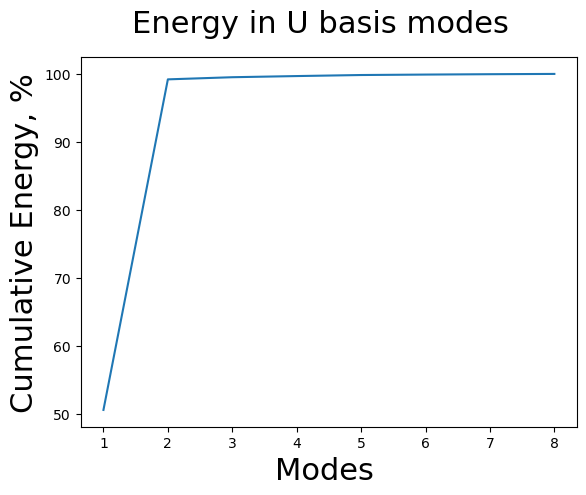

In [ ]:
Um, PhiU, interpolators_U,result_sample1=train_AI_for_winddirection(U.T,'U',nr)

# Reconstruct Velocity for wind direction as parameter

In [175]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples1,df_transformed,timetaken=reconstruct_AI_for_winddirection("U",wind_direc,nr,fn,vectorU=True)
#result_sample1.save('./Results/recon_added_' +'f{variable}'+'.vtk')

[184, 22, 215, 71, 308]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_rbf_interpolators.pkl
Interpolating coefficient for wind direction


CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_184_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_184_Output_Transformed.csv
Interpolating coefficient for wind direction
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_22_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_22_Output_Transformed.csv
Interpolating coefficient for wind direction
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_215_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_215_Output_Transformed.csv
Interpolating coefficient for wind direction
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_71_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Re

# Train for only wind direction : Turbulence from AI

At (125000, 8)
U (125000, 8) S (8,) V (8, 8)
Phit (125000, 8) Lt (8,)


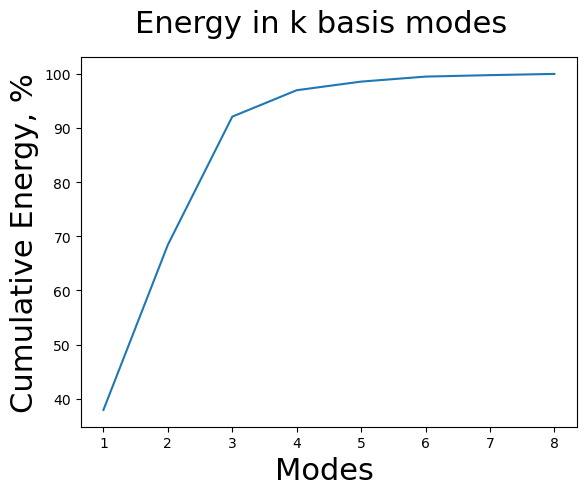

In [ ]:
km, kU, interpolators_k,result_sample_k=train_AI_for_winddirection(k.T,'k',nr,vectorU=False)

In [ ]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

# Reconstruct Turbulence for wind direction as parameter

In [ ]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples_k,df_k_offset,timetaken=reconstruct_AI_for_winddirection("k",wind_direc,nr,fn,vectorU=False)

[239, 248, 42, 4, 170]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators.pkl
Coeff for mode 1 is  57.24855983714315
Coeff for mode 2 is  -14.389811324520224
Coeff for mode 3 is  -32.07723172133519
Coeff for mode 4 is  -10.394690751466015
Coeff for mode 5 is  -2.351193657868805
Coeff for mode 6 is  9.88468360624502
Coeff for mode 7 is  5.910112417491225
Coeff for mode 8 is  -3.919714534360942


CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_239_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_239_Output_Transformed.csv
Coeff for mode 1 is  51.583728802258406
Coeff for mode 2 is  16.253131437503157
Coeff for mode 3 is  -25.320624092715608
Coeff for mode 4 is  -16.50416209909318
Coeff for mode 5 is  3.691471350162601
Coeff for mode 6 is  7.38056628876609
Coeff for mode 7 is  6.393665835609571
Coeff for mode 8 is  -3.2553675779767417
CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_248_Output.csv
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_248_Output_Transformed.csv
Coeff for mode 1 is  61.31447331447089
Coeff for mode 2 is  55.34685635749872
Coeff for mode 3 is  40.91860358095337
Coeff for mode 4 is  3.281201705533647
Coeff for mode 5 is  -6.658837478315945
Coeff for mode 6 is  11.705157

In [ ]:
df_k_offset

,X,Y,Z,tke
0,-500.0,-450.013000,245.558,-0.000013
1,-500.0,-431.645102,245.558,-0.000013
2,-500.0,-413.277204,245.558,-0.000013
3,-500.0,-394.909306,245.558,-0.000013
4,-500.0,-376.541408,245.558,-0.000013
...,...,...,...,...
124995,500.0,376.542408,529.000,0.355924
124996,500.0,394.910306,529.000,0.353359
124997,500.0,413.278204,529.000,0.350703
124998,500.0,431.646102,529.000,0.348000


In [ ]:
df_transformed

,X,Y,Z,Velocity_X_,Velocity_Y_,Velocity_Z_
0,-500.0,-450.013000,245.558,6.930126e-10,6.926908e-10,6.926908e-10
1,-500.0,-431.645102,245.558,6.926908e-10,6.926908e-10,6.926908e-10
2,-500.0,-413.277204,245.558,6.926908e-10,6.926908e-10,6.926908e-10
3,-500.0,-394.909306,245.558,6.926908e-10,6.926908e-10,6.926908e-10
4,-500.0,-376.541408,245.558,6.926908e-10,6.926908e-10,6.926908e-10
...,...,...,...,...,...,...
124995,500.0,376.542408,529.000,-2.550472e-02,6.599885e-01,-6.478669e-03
124996,500.0,394.910306,529.000,-2.550015e-02,6.594477e-01,-6.451907e-03
124997,500.0,413.278204,529.000,-2.549619e-02,6.589119e-01,-6.389843e-03
124998,500.0,431.646102,529.000,-2.549323e-02,6.583826e-01,-6.315094e-03


In [ ]:
merged_df_U_k_Relative_2_vertiport_reconstructed = pd.merge(df_k_offset, df_transformed, on=['X','Y','Z'], how='outer')

In [ ]:
merged_df_U_k_Relative_2_vertiport_reconstructed

,X,Y,Z,tke,Velocity_X_,Velocity_Y_,Velocity_Z_,latitude,longitude
0,-500.0,-450.013,245.558000,-0.000013,6.930126e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
1,-500.0,-450.013,251.342531,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
2,-500.0,-450.013,257.127061,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
3,-500.0,-450.013,262.911592,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
4,-500.0,-450.013,268.696122,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
...,...,...,...,...,...,...,...,...,...
124995,500.0,450.014,505.861878,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124996,500.0,450.014,511.646408,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124997,500.0,450.014,517.430939,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124998,500.0,450.014,523.215469,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981


In [ ]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

In [ ]:
# Obtain latitude and longitude of domain points based on simple approximation.

In [ ]:
import math
ref_long_at_vertiport=14.4379744
ref_latitude_at_vertiport=50.0499086
#Latitude is the Y axis, longitude is the X axis. Belo since X,Y are relative to vertiport. Hence, we use this to obtain relative change in latitude/long from vertiport. then add reference to this change to get actual latitude and longitude.
merged_df_U_k_Relative_2_vertiport_reconstructed['latitude']=(merged_df_U_k_Relative_2_vertiport_reconstructed['Y'] / 111139)+ref_latitude_at_vertiport
lat_rad= math.radians(ref_latitude_at_vertiport) #merged_df_U_k_Relative_2_vertiport_reconstructed['latitude'].apply(math.radians)
#lat_rad.apply(math.cos)
cos_lat_rad=math.cos(lat_rad)
merged_df_U_k_Relative_2_vertiport_reconstructed['longitude']=(merged_df_U_k_Relative_2_vertiport_reconstructed['X'] / (111139 * cos_lat_rad))+ref_long_at_vertiport

In [ ]:
merged_df_U_k_Relative_2_vertiport_reconstructed.to_pickle(fn+'/'+'merged')

In [ ]:
merged_df_U_k_Relative_2_vertiport_reconstructed

,X,Y,Z,tke,Velocity_X_,Velocity_Y_,Velocity_Z_,latitude,longitude
0,-500.0,-450.013,245.558000,-0.000013,6.930126e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
1,-500.0,-450.013,251.342531,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
2,-500.0,-450.013,257.127061,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
3,-500.0,-450.013,262.911592,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
4,-500.0,-450.013,268.696122,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.045859,14.430968
...,...,...,...,...,...,...,...,...,...
124995,500.0,450.014,505.861878,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124996,500.0,450.014,511.646408,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124997,500.0,450.014,517.430939,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981
124998,500.0,450.014,523.215469,-0.000013,6.926908e-10,6.926908e-10,6.926908e-10,50.053958,14.444981


current_dir = os.getcwd()    # Get the current directory 
sys.path.append(current_dir)

In [ ]:
# Example usage: Z>267,-400>X>400,-400>Y>400
X_input = 240  # Change this to the X coordinate you want to search for
Y_input = 270  # Change this to the Y coordinate you want to search for
Z_input = 339  # Change this to the Z coordinate you want to search for

nearest_location = get_U_and_k_for_location(X_input, Y_input, Z_input,merged_df_U_k_Relative_2_vertiport_reconstructed)

vx=nearest_location['Velocity_X_']
vy=nearest_location['Velocity_Y_']
vz=nearest_location['Velocity_Z_']
Ucomponent=[vx,vy,vz]
U_values = math.sqrt(vx**2 + vy**2 + vz**2) 
k_values = nearest_location['tke']


Latitude and longitude are within bounds. Proceeding with further processing.
using nearest based on distance
nearest X              234.693878
Y              266.335020
Z              338.110490
tke              0.068197
Velocity_X_     -0.027110
Velocity_Y_      0.569999
Velocity_Z_      0.001359
latitude        50.052305
longitude       14.441263
Name: 91966, dtype: float64 91966


In [ ]:
nearest_location

X              234.693878
Y              266.335020
Z              338.110490
tke              0.068197
Velocity_X_     -0.027110
Velocity_Y_      0.569999
Velocity_Z_      0.001359
latitude        50.052305
longitude       14.441263
Name: 91966, dtype: float64

In [ ]:
dataset_nearest_latlong =get_U_and_k_for_location(nearest_location['longitude']+0.001,nearest_location['latitude'],Z_input,merged_df_U_k_Relative_2_vertiport_reconstructed,relative_distance_in_meter__or__Latlong='relat')
#print(dataset_nearest_latlong)

Latitude and longitude are within bounds. Proceeding with further processing.
Empty DataFrame
Columns: [X, Y, Z, tke, Velocity_X_, Velocity_Y_, Velocity_Z_, latitude, longitude]
Index: []
using nearest based on lat-long. Haversten  not used.
nearest X              295.918367
Y              266.335020
Z              338.110490
tke              0.086706
Velocity_X_     -0.010882
Velocity_Y_      0.545687
Velocity_Z_     -0.003137
latitude        50.052305
longitude       14.442121
Name: 99466, dtype: float64 99466


In [ ]:
#if type(dataset_nearest_latlong)== pandas.core.series.Series:
dataset_nearest_latlongdataset_nearest_latlong.to_frame()
print(type(dataset_nearest_latlong))
    

<class 'pandas.core.series.Series'>


In [ ]:
type(dataset_nearest_latlong)

pandas.core.series.Series

In [ ]:
mport matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_plot(df):
    df=df.to_frame()
    
    




# Plot 3D terrain map
#fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'gray')  # Plot terrain map

# Plot drone's trajectory with colored line representing turbulence
for i in range(df.shape[0]):
    ax.plot(df.iloc[i], y[i:i+2], z[i:i+2], color=plt.cm.jet(turbulence[i]))

# Add color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='jet'))
cbar.set_label('Turbulence')

plt.show()


In [ ]:
print(dataset_nearest_latlong)

X               91.836735
Y              192.863429
Z              268.696122
tke              0.013665
Velocity_X_     -0.059364
Velocity_Y_      0.177378
Velocity_Z_     -0.005838
latitude        50.051644
longitude       14.439261
Name: 74254, dtype: float64


In [ ]:
latitude        50.051644
longitude       14.439261

In [ ]:
merged_df_U_k_Relative_2_vertiport_reconstructed.loc[2000]

X             -5.000000e+02
Y              2.847029e+02
Z              2.455580e+02
tke           -1.301730e-05
Velocity_X_    6.926908e-10
Velocity_Y_    6.926908e-10
Velocity_Z_    6.926908e-10
Name: 2000, dtype: float64

In [ ]:
result_samples_k.save('./Results/recon_added_' +'k_var'+'.vtk')

csv_file = fn+'/'+ f'U'+'_'+str(wind_dir)+'_Output.csv'     
df=pd.read_csv(csv_file)
#Make vertiport at 0,0,267. x=x-1480,y=y+2120,z=z+229.
deltaX=-1480
deltaY=2120
deltaZ=229
df=offset_dataset(deltaX,deltaY,deltaZ,df)
df.to_csv(fn+'/'+ f'{variable}'+'_'+str(wind_dir)+'_Output_Transformed.csv', index=False)

print("Transformation completed. Output saved to:", output_path)

In [ ]:
#Below is code for k
# Things to do :

#Test the above function for tke_at_wind_dire
#Save reconstructed into format X,Y,Z,U,V,W,k using ROM_windturbine.ipynb
#Convert X,Y,Z into latl/long and UTM.
#Code to obtain U and k from the nearest chosen lat/long and UTM.


#Attempt to take feedback

# Do U and k for all wind speeds using windspeed as one of rbf interpolators


In [130]:
kall.T.shape

(125000, 32)

In [111]:
nr

32

In [160]:
Uall.T.shape

(375000, 32)

# New Train for all wind speed and wind directions

At (125000, 32)
U (125000, 32) S (32,) V (32, 32)
Phit (125000, 32) Lt (32,)


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8]
[array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00])]
4
[array([-1.83697020e-16,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
       -7.07106781e-01, -7.07106781e-01, -1.00000000e+00,  6.12323400e-17]), array([-1.83697020e-16,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
       -7.07106781e-01, -7.07106

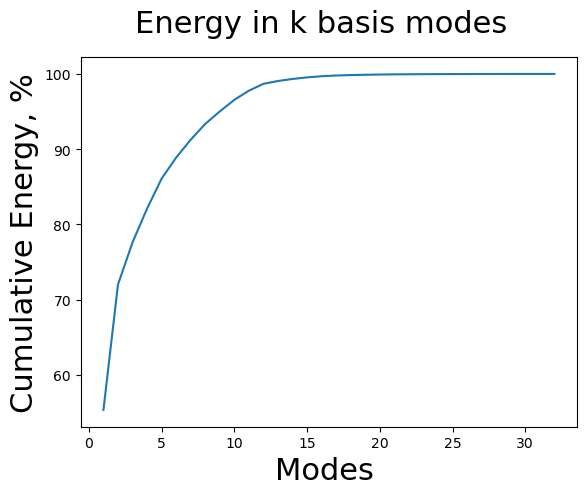

In [138]:
km, kU, interpolators_k,result_sample_k=train_AI_for_winddirection_windspeed(kall.T,'k',nr,vectorU=False)

In [139]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

In [158]:
result_sample.clear_data()

In [159]:
random.seed(10)
wind_direcall = [random.randint(0, 360) for _ in range(3)]
print(wind_direcall)

wind_speed_call = [random.uniform(0.5, 8) for _ in range(3)]
print(wind_speed_call)

result_samples_kall,df_k_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("k",wind_direcall,wind_speed_call,fn,vectorU=False)

[292, 16, 219]
[4.1192125591314195, 0.6112433451841527, 3.9693538106971187]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators_all.pkl
wind speed 4.1192125591314195
wind direction 292
Coeff for mode 1 is  -69.14684757767782
Coeff for mode 2 is  61.19633383320581
Coeff for mode 3 is  -56.51120498877481
Coeff for mode 4 is  19.758990432468636
Coeff for mode 5 is  -16.891737239336408
Coeff for mode 6 is  16.404071456052407
Coeff for mode 7 is  -5.003964494340835
Coeff for mode 8 is  -24.31308143177921
Coeff for mode 9 is  1.9279990056020324
Coeff for mode 10 is  -15.392990149694242
Coeff for mode 11 is  15.766858495897395
Coeff for mode 12 is  -12.81404405232388
Coeff for mode 13 is  -2.9446906141438376
Coeff for mode 14 is  13.294447647080233
Coeff for mode 15 is  -12.214548236767655
Coeff for mode 16 is  5.986398609164098
Coeff for mode 17 is  -1.8940244562852513
Coeff for mode 18 is  2.110217464383936
Coeff for mode 19 is  -4.270823957122502
Coeff for mode 20 is

In [150]:
# Check if you are able to reconstruct training field
wind_direcall = [90,45,315,360,135,225,180,270]
print(wind_direcall)

wind_speed_call = [0.5,2.5,5,8] #50 m above height. Mast location. Prague.
print(wind_speed_call)

result_samples_kall,df_k_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("k",wind_direcall,wind_speed_call,fn,vectorU=False)

[90, 45, 315, 360, 135, 225, 180, 270]
[0.5, 2.5, 5, 8]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators_all.pkl
wind speed 0.5
wind direction 90
Coeff for mode 1 is  71.01018524167739
Coeff for mode 2 is  121.8894577026374
Coeff for mode 3 is  31.43614006043117
Coeff for mode 4 is  -18.06645584107673
Coeff for mode 5 is  41.963554382331495
Coeff for mode 6 is  -17.471572875974744
Coeff for mode 7 is  17.491886138912378
Coeff for mode 8 is  15.533255577078307
Coeff for mode 9 is  3.4839348793175304
Coeff for mode 10 is  5.751782894134976
Coeff for mode 11 is  -19.06791114806947
Coeff for mode 12 is  18.62007141113645
Coeff for mode 13 is  -19.0739650726332
Coeff for mode 14 is  15.931261062617978
Coeff for mode 15 is  -4.149491310118947
Coeff for mode 16 is  -1.884652137754074
Coeff for mode 17 is  -1.6083748340605553
Coeff for mode 18 is  -8.47912788391028
Coeff for mode 19 is  0.050188720225833094
Coeff for mode 20 is  -3.3600766658780685
Coeff for mode 21 i

Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/CSV_Database/k_90_Output_Transformed_all.csv
wind speed 2.5
wind direction 90
Coeff for mode 1 is  -6.506278991708314
Coeff for mode 2 is  86.19619750976358
Coeff for mode 3 is  43.72839355468341
Coeff for mode 4 is  -14.201072692874732
Coeff for mode 5 is  34.04603576660429
Coeff for mode 6 is  -24.68915748595191
Coeff for mode 7 is  17.22028923034668
Coeff for mode 8 is  0.04666501283281832
Coeff for mode 9 is  18.442312240604224
Coeff for mode 10 is  3.387354135521832
Coeff for mode 11 is  2.3941202163741764
Coeff for mode 12 is  -10.530595779422583
Coeff for mode 13 is  -12.874435424804005
Coeff for mode 14 is  8.235624313353583
Coeff for mode 15 is  -0.38268870115246045
Coeff for mode 16 is  -16.092386245728903
Coeff for mode 17 is  0.6551619768144405
Coeff for mode 18 is  3.1824412345880546
Coeff for mode 19 is  0.5273498296731418
Coeff for mode 20 is  -5.671189308167243
Coeff for mo

At (375000, 32)
U (375000, 32) S (32,) V (32, 32)
Phit (375000, 32) Lt (32,)
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8]
[array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00]), array([-1.00000000e+00,  7.07106781e-01, -7.07106781e-01, -2.44929360e-16,
        7.07106781e-01, -7.07106781e-01,  1.22464680e-16,  1.00000000e+00])]
4
[array([-1.83697020e-16,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
       -7.07106781e-01, -7.07106781e-01, -1.00000000e+00,  6.12323400e-17]), array([-1.83697020e-16,  7.071

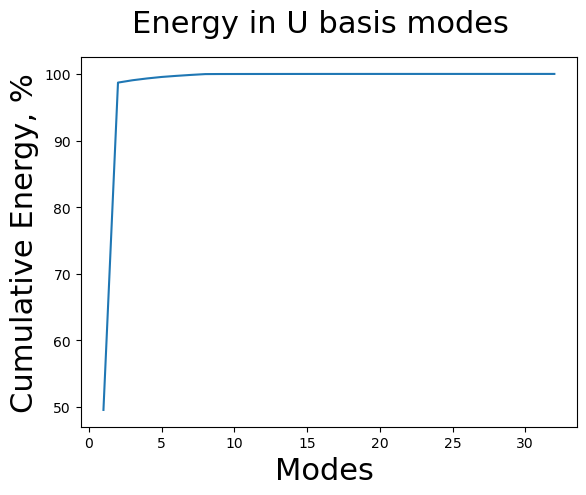

In [168]:
Um_all, PhiU_all, interpolators_U_all,result_sample_U_all=train_AI_for_winddirection_windspeed(Uall.T,'U',nr,vectorU=True)


In [169]:
result_samples_Uall,df_U_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("U",wind_direcall,wind_speed_call,fn,vectorU=True)

/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_rbf_interpolators_all.pkl
wind speed 4.1192125591314195
wind direction 292
Coeff for mode 1 is  215.1057837689914
Coeff for mode 2 is  -1534.9343227843156
Coeff for mode 3 is  -91.1348633535963
Coeff for mode 4 is  60.71349426459528
Coeff for mode 5 is  -53.76228198401441
Coeff for mode 6 is  39.333520695705374
Coeff for mode 7 is  31.117573330309824
Coeff for mode 8 is  -16.007538940160885
Coeff for mode 9 is  41.288444481953775
Coeff for mode 10 is  16.39872005141224
Coeff for mode 11 is  2.2174896809933387
Coeff for mode 12 is  4.235952539796585
Coeff for mode 13 is  0.4739838383222832
Coeff for mode 14 is  1.6592909254023027
Coeff for mode 15 is  1.1336000003084337
Coeff for mode 16 is  -0.7163863685227625
Coeff for mode 17 is  3.4895634572402514
Coeff for mode 18 is  -0.9668174330066108
Coeff for mode 19 is  -3.2320358634564172
Coeff for mode 20 is  1.167068884922628
Coeff for mode 21 is  0.38107073843990236
Coeff for mode 2

CSV file saved successfully: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/CSV_Database/U_292_4.1192125591314195_Output_all.csv
Directory '/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/VTK_Database' already exists.
VTK reconstruction saved at: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/VTK_Database/Recon_VTK_added_all_ws_wdU.vtk
Directory '/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/CSV_Database' already exists.
Transformation completed. Output saved to: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/CSV_Database/U_292_Output_Transformed_all.csv
wind speed 0.6112433451841527
wind direction 292
Coeff for mode 1 is  26.617753917586015
Coeff for mode 2 is  -204.90626969878667
Coeff for mode 3 is  -12.586011802282883
Coeff for mode 4 is  8.050899001433208
Coeff for mode 5 is  -7.15265556905797
Coeff for mode 6 is  5.334630705030577
Coeff for mode 7 is  3.422538517785142
Coeff for mode 8 is  -2.3673073875979753
Coeff for mode 9 is  -3.7820415

In [213]:
# Check if you are able to reconstruct training field
wind_direcall = [90,45,315,360,135,225,180,270]
print(wind_direcall)

wind_speed_call = [0.5,2.5,5,8] #50 m above height. Mast location. Prague.
print(wind_speed_call)

#result_samples_Uall,df_U_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("U",wind_direcall,wind_speed_call,fn,vectorU=True)
result_samples_kall,df_k_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("k",wind_direcall,wind_speed_call,fn,vectorU=False)


[90, 45, 315, 360, 135, 225, 180, 270]
[0.5, 2.5, 5, 8]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators_all.pkl
wind speed 0.5
wind direction 90
Coeff for mode 1 is  71.01018524167739
Coeff for mode 2 is  121.8894577026374
Coeff for mode 3 is  31.43614006043117
Coeff for mode 4 is  -18.06645584107673
Coeff for mode 5 is  41.963554382331495
Coeff for mode 6 is  -17.471572875974744
Coeff for mode 7 is  17.491886138912378
Coeff for mode 8 is  15.533255577078307
Coeff for mode 9 is  3.4839348793175304
Coeff for mode 10 is  5.751782894134976
Coeff for mode 11 is  -19.06791114806947
Coeff for mode 12 is  18.62007141113645
Coeff for mode 13 is  -19.0739650726332
Coeff for mode 14 is  15.931261062617978
Coeff for mode 15 is  -4.149491310118947
Coeff for mode 16 is  -1.884652137754074
Coeff for mode 17 is  -1.6083748340605553
Coeff for mode 18 is  -8.47912788391028
Coeff for mode 19 is  0.050188720225833094
Coeff for mode 20 is  -3.3600766658780685
Coeff for mode 21 i

In [245]:
# Check if you are able to reconstruct test field
wind_direcall = [120]
print(wind_direcall)

wind_speed_call = [3,8,9] #50 m above height. Mast location. Prague.
print(wind_speed_call)

#result_samples_Uall,df_U_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("U",wind_direcall,wind_speed_call,fn,vectorU=True)
result_samples_kall,df_k_offsetall,timetakenall=reconstruct_AI_for_winddirection_windspeed("k",wind_direcall,wind_speed_call,fn,vectorU=False)


[120]
[3, 8, 9]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators_all.pkl
wind speed 3
wind direction 120
Coeff for mode 1 is  -29.960793259640468
Coeff for mode 2 is  78.82092569981091
Coeff for mode 3 is  42.32735179928159
Coeff for mode 4 is  -26.972623603774082
Coeff for mode 5 is  4.490117706503497
Coeff for mode 6 is  -26.947600392568347
Coeff for mode 7 is  10.593927008227183
Coeff for mode 8 is  8.916718536834196
Coeff for mode 9 is  26.478321758218954
Coeff for mode 10 is  -7.921430771369955
Coeff for mode 11 is  12.414619766300348
Coeff for mode 12 is  -15.991411419678116
Coeff for mode 13 is  -8.227046117509872
Coeff for mode 14 is  -5.054996440876494
Coeff for mode 15 is  -12.165440017665105
Coeff for mode 16 is  -4.781112136754928
Coeff for mode 17 is  1.043783747442518
Coeff for mode 18 is  4.218509194824037
Coeff for mode 19 is  5.155842690028635
Coeff for mode 20 is  0.4609735337070333
Coeff for mode 21 is  -1.4629587440674072
Coeff for mode 22 

In [247]:
result_samples_Uall,df_U_offsetall,timetakenall==reconstruct_AI_for_winddirection_windspeed("U",wind_direcall,wind_speed_call,fn,vectorU=True)

/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_rbf_interpolators_all.pkl
wind speed 3
wind direction 120
Coeff for mode 1 is  -9.245672210196062
Coeff for mode 2 is  1108.4191200104542
Coeff for mode 3 is  -61.79814568172151
Coeff for mode 4 is  29.095971472735982
Coeff for mode 5 is  -63.68883695103068
Coeff for mode 6 is  -6.266202790939133
Coeff for mode 7 is  -19.8936711023307
Coeff for mode 8 is  27.498139012110187
Coeff for mode 9 is  0.6649896633448407
Coeff for mode 10 is  -6.312173408969443
Coeff for mode 11 is  4.208212280327416
Coeff for mode 12 is  16.071572639682813
Coeff for mode 13 is  17.140996787758894
Coeff for mode 14 is  -5.041098597639959
Coeff for mode 15 is  -0.6652459444561885
Coeff for mode 16 is  8.954587258703441
Coeff for mode 17 is  -0.8545651304212356
Coeff for mode 18 is  -0.7682338634738244
Coeff for mode 19 is  0.814117996056325
Coeff for mode 20 is  1.2501033575528595
Coeff for mode 21 is  -0.2624909355972136
Coeff for mode 22 is  -1.29257500

(StructuredGrid (0x7f62b666e200)
   N Cells:      117649
   N Points:     125000
   X Bounds:     9.800e+02, 1.980e+03
   Y Bounds:     -2.570e+03, -1.670e+03
   Z Bounds:     1.656e+01, 3.000e+02
   Dimensions:   50, 50, 50
   N Arrays:     195,
             X           Y        Z   Velocity_X_   Velocity_Y_   Velocity_Z_
 0      -500.0 -450.013000  245.558 -5.973924e-08 -5.976862e-08 -5.976862e-08
 1      -500.0 -431.645102  245.558 -5.975902e-08 -5.976862e-08 -5.976862e-08
 2      -500.0 -413.277204  245.558 -5.976862e-08 -5.976862e-08 -5.976862e-08
 3      -500.0 -394.909306  245.558 -5.976862e-08 -5.976862e-08 -5.976862e-08
 4      -500.0 -376.541408  245.558 -5.976862e-08 -5.976862e-08 -5.976862e-08
 ...       ...         ...      ...           ...           ...           ...
 124995  500.0  376.542408  529.000  1.139501e+01 -4.969850e-02  2.281698e-01
 124996  500.0  394.910306  529.000  1.138957e+01 -4.200131e-02  2.434124e-01
 124997  500.0  413.278204  529.000  1.138529e+01 -

In [181]:
result_samples_Uall.array_names

['RECON_tke_at_WD_WS292_4.1192125591314195',
 'RECON_tke_at_WD_WS292_0.6112433451841527',
 'RECON_tke_at_WD_WS292_3.9693538106971187',
 'RECON_tke_at_WD_WS16_4.1192125591314195',
 'RECON_tke_at_WD_WS16_0.6112433451841527',
 'RECON_tke_at_WD_WS16_3.9693538106971187',
 'RECON_tke_at_WD_WS219_4.1192125591314195',
 'RECON_tke_at_WD_WS219_0.6112433451841527',
 'RECON_tke_at_WD_WS219_3.9693538106971187',
 'Phi_U_0',
 'Phi_U_1',
 'Phi_U_2',
 'Phi_U_3',
 'Phi_U_4',
 'Phi_U_5',
 'Phi_U_6',
 'Phi_U_7',
 'Phi_U_8',
 'Phi_U_9',
 'Phi_U_10',
 'Phi_U_11',
 'Phi_U_12',
 'Phi_U_13',
 'Phi_U_14',
 'Phi_U_15',
 'Phi_U_16',
 'Phi_U_17',
 'Phi_U_18',
 'Phi_U_19',
 'Phi_U_20',
 'Phi_U_21',
 'Phi_U_22',
 'Phi_U_23',
 'Phi_U_24',
 'Phi_U_25',
 'Phi_U_26',
 'Phi_U_27',
 'Phi_U_28',
 'Phi_U_29',
 'Phi_U_30',
 'Phi_U_31',
 'RECON_U_at_WD_WS292_4.1192125591314195',
 'RECON_U_at_WD_WS292_0.6112433451841527',
 'RECON_U_at_WD_WS292_3.9693538106971187',
 'RECON_U_at_WD_WS16_4.1192125591314195',
 'RECON_U_at_WD_WS16_

In [182]:
Uall.shape

(32, 375000)

In [184]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEast/VTK/Prague_0p5_mps_NorthEast_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWest/VTK/Prague_0p5_mps_NorthWest_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterlyActually/VTK/Prague_0p5_mps_SouthEasterlyActually_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWest/VTK/Prague_0p5_mps_SouthWest_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_Westerly

In [185]:
Uall.shape

(32, 375000)

In [192]:
result_samples_kall.array_names

['RECON_tke_at_WD_WS292_4.1192125591314195',
 'RECON_tke_at_WD_WS292_0.6112433451841527',
 'RECON_tke_at_WD_WS292_3.9693538106971187',
 'RECON_tke_at_WD_WS16_4.1192125591314195',
 'RECON_tke_at_WD_WS16_0.6112433451841527',
 'RECON_tke_at_WD_WS16_3.9693538106971187',
 'RECON_tke_at_WD_WS219_4.1192125591314195',
 'RECON_tke_at_WD_WS219_0.6112433451841527',
 'RECON_tke_at_WD_WS219_3.9693538106971187',
 'Phi_U_0',
 'Phi_U_1',
 'Phi_U_2',
 'Phi_U_3',
 'Phi_U_4',
 'Phi_U_5',
 'Phi_U_6',
 'Phi_U_7',
 'Phi_U_8',
 'Phi_U_9',
 'Phi_U_10',
 'Phi_U_11',
 'Phi_U_12',
 'Phi_U_13',
 'Phi_U_14',
 'Phi_U_15',
 'Phi_U_16',
 'Phi_U_17',
 'Phi_U_18',
 'Phi_U_19',
 'Phi_U_20',
 'Phi_U_21',
 'Phi_U_22',
 'Phi_U_23',
 'Phi_U_24',
 'Phi_U_25',
 'Phi_U_26',
 'Phi_U_27',
 'Phi_U_28',
 'Phi_U_29',
 'Phi_U_30',
 'Phi_U_31',
 'RECON_U_at_WD_WS292_4.1192125591314195',
 'RECON_U_at_WD_WS292_0.6112433451841527',
 'RECON_U_at_WD_WS292_3.9693538106971187',
 'RECON_U_at_WD_WS16_4.1192125591314195',
 'RECON_U_at_WD_WS16_

In [210]:
def add_original_field_at_coarse_mesh_for_comparison(wind_direc,windspeed,result_samples_Uall,result_samples_kall,Uall,kall):
    count=0
    for wind_spee in windspeed:
        for wind_dir in wind_direc:
            print("Column accessed : ",f"{count}")
            #print(count) 
            print (f"wind speed {wind_spee}")
            print (f"wind direction {wind_dir}")
    
            #if vectorU==False:
            result_samples_kall.point_data["original_tke_at_WD_WS"+str(wind_dir)+"_"+str(wind_spee)]=kall[count,:] #tke_at_wind_direction                                       
            #else:
            
            U_reshaped=Uall[count,:].reshape(-1, 3, order='F') 
            
            result_samples_Uall.point_data.set_vectors(U_reshaped,"original_U_at_WD_WS"+str(wind_dir)+"_"+str(wind_spee))
            #df=save_csv_reconstructed_all(result_sample,variable,wind_dir,wind_spee,fn,vectorU)
                        
            
            
            count=count+1  
              
    path1=os.path.join(fn,'VTK_Database')
    if not os.path.exists(path1):
        
        # If it doesn't exist, create the directory
        os.makedirs(path1)
        print(f"Directory '{path1}' created successfully.")
    else:
        print(f"Directory '{path1}' already exists.") 
                    
    variable='U' 
    result_samples_Uall.save(path1+'/Recon_and_original_VTK_added_all_ws_wd_' +f"{variable}"+'.vtk')
    print("VTK reconstruction saved at:", path1+'/Recon_and_original_VTK_added_all_ws_wd_' +f"{variable}"+'.vtk') 
        
    variable='k' 
    result_samples_kall.save(path1+'/Recon_and_original_VTK_added_all_ws_wd_' +f"{variable}"+'.vtk')
    print("VTK reconstruction saved at:", path1+'/Recon_and_original_VTK_added_all_ws_wd_' +f"{variable}"+'.vtk') 

    return result_samples_Uall,result_samples_kall      
          

In [214]:
#Do not change wind direction here as we are comparing with original velocity and tke.
wind_direcall = [270,45,315,360,135,225,180,90]
print(wind_direcall)

wind_speed_call = [0.5,2.5,5,8] #50 m above height. Mast location. Prague.
print(wind_speed_call)

result_samples_Uall,result_samples_kall=add_original_field_at_coarse_mesh_for_comparison(wind_direcall,wind_speed_call,result_sample_U_all,result_samples_kall,Uall,kall)

[270, 45, 315, 360, 135, 225, 180, 90]
[0.5, 2.5, 5, 8]
Column accessed :  0
wind speed 0.5
wind direction 270
Column accessed :  1
wind speed 0.5
wind direction 45
Column accessed :  2
wind speed 0.5
wind direction 315
Column accessed :  3
wind speed 0.5
wind direction 360
Column accessed :  4
wind speed 0.5
wind direction 135
Column accessed :  5
wind speed 0.5
wind direction 225
Column accessed :  6
wind speed 0.5
wind direction 180
Column accessed :  7
wind speed 0.5
wind direction 90
Column accessed :  8
wind speed 2.5
wind direction 270
Column accessed :  9
wind speed 2.5
wind direction 45
Column accessed :  10
wind speed 2.5
wind direction 315
Column accessed :  11
wind speed 2.5
wind direction 360
Column accessed :  12
wind speed 2.5
wind direction 135
Column accessed :  13
wind speed 2.5
wind direction 225
Column accessed :  14
wind speed 2.5
wind direction 180
Column accessed :  15
wind speed 2.5
wind direction 90
Column accessed :  16
wind speed 5
wind direction 270
Column a

In [242]:
result_samples_kall

StructuredGrid (0x7f62b666e200)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     189

In [243]:
# Testing: Do not change wind direction here as we are comparing with original velocity and tke.
wind_direcall = [120]
print(wind_direcall)

wind_speed_call = [3,8] #50 m above height. Mast location. Prague.
print(wind_speed_call)

result_samples_Uall,result_samples_kall=add_original_field_at_coarse_mesh_for_comparison(wind_direcall,wind_speed_call,result_sample_U_all,result_samples_kall,Utestall,ktestall)

[120]
[3, 8]
Column accessed :  0
wind speed 3
wind direction 120
Column accessed :  1
wind speed 8
wind direction 120
Directory '/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/VTK_Database' already exists.
VTK reconstruction saved at: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/VTK_Database/Recon_and_original_VTK_added_all_ws_wdU.vtk
VTK reconstruction saved at: /media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/VTK_Database/Recon_and_original_VTK_added_all_ws_wdk.vtk


In [244]:
result_samples_Uall.array_names

['RECON_tke_at_WD_WS292_4.1192125591314195',
 'RECON_tke_at_WD_WS292_0.6112433451841527',
 'RECON_tke_at_WD_WS292_3.9693538106971187',
 'RECON_tke_at_WD_WS16_4.1192125591314195',
 'RECON_tke_at_WD_WS16_0.6112433451841527',
 'RECON_tke_at_WD_WS16_3.9693538106971187',
 'RECON_tke_at_WD_WS219_4.1192125591314195',
 'RECON_tke_at_WD_WS219_0.6112433451841527',
 'RECON_tke_at_WD_WS219_3.9693538106971187',
 'Phi_U_0',
 'Phi_U_1',
 'Phi_U_2',
 'Phi_U_3',
 'Phi_U_4',
 'Phi_U_5',
 'Phi_U_6',
 'Phi_U_7',
 'Phi_U_8',
 'Phi_U_9',
 'Phi_U_10',
 'Phi_U_11',
 'Phi_U_12',
 'Phi_U_13',
 'Phi_U_14',
 'Phi_U_15',
 'Phi_U_16',
 'Phi_U_17',
 'Phi_U_18',
 'Phi_U_19',
 'Phi_U_20',
 'Phi_U_21',
 'Phi_U_22',
 'Phi_U_23',
 'Phi_U_24',
 'Phi_U_25',
 'Phi_U_26',
 'Phi_U_27',
 'Phi_U_28',
 'Phi_U_29',
 'Phi_U_30',
 'Phi_U_31',
 'RECON_U_at_WD_WS292_4.1192125591314195',
 'RECON_U_at_WD_WS292_0.6112433451841527',
 'RECON_U_at_WD_WS292_3.9693538106971187',
 'RECON_U_at_WD_WS16_4.1192125591314195',
 'RECON_U_at_WD_WS16_

In [ ]:
# ENDS HERE

#  ---------------------------------------------------------------------------------------

#  ----------------------------------------------------------------------------------